<a href="https://colab.research.google.com/github/khushimitr/PubMedAbstracts/blob/main/PubMed_20K_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The purpose of this notebook is to build an NLP model to make reading
abstracts easier. (Many to One Sequencial Modelling)

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-bdb6c0bc-82fc-1930-2393-982e61858997)


## Get Data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

**Randomized Controlled Trial (RCT).**

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocessing Data (Become One with Data)

In [6]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename(.txt) and returns the lines of text as a list.
    """
    with open(filename,'r') as f:
        return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040


How we want data to look like for our model

```
[{ 'line_number' : 0,
   'target' : "BACKGROUND",
   'text' : "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines' : 11 }]
```

In [9]:
def preprocess_text(filename):
    """
    Returns a list of dictionary of abstract line data
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_lines_split = abstract_lines.splitlines()

            for abstract_ln_no, abstract_ln in enumerate(abstract_lines_split):
                data = {}
                target_text_split = abstract_ln.split("\t")
                data["target"] = target_text_split[0]
                data["text"] = target_text_split[1].lower()
                data["line_number"] = abstract_ln_no
                data["total_lines"] = len(abstract_lines_split) - 1
                abstract_samples.append(data)
        else:
            abstract_lines += line

    return abstract_samples

In [10]:
# Get data from file and preprocess
%%time
val_samples = preprocess_text(data_dir + "dev.txt")
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 464 ms, sys: 105 ms, total: 569 ms
Wall time: 570 ms


In [11]:
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# distrubution of labels in training Data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

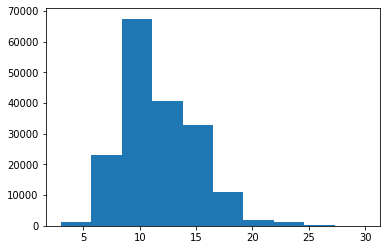

In [14]:
# Let's Check the length of different lines
train_df.total_lines.hist(grid = False)

### Get list of Sentences

In [15]:
train_sen = train_df["text"].tolist()
val_sen = val_df["text"].tolist()
test_sen = test_df["text"].tolist()
print(len(train_sen),len(val_sen),len(test_sen))

180040 30212 30135


In [16]:
train_sen[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric Labels

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_oh = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_oh = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_oh = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_oh

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
# Integer Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Download helper function script

In [20]:
!wget https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py

from helperfunctions import calculate_results

--2022-01-19 15:03:23--  https://raw.githubusercontent.com/khushimitr/HandGestureRecognition/main/helperfunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9735 (9.5K) [text/plain]
Saving to: ‘helperfunctions.py’

helperfunctions.py  100%[===================>]   9.51K  --.-KB/s    in 0s      

2022-01-19 15:03:24 (73.4 MB/s) - ‘helperfunctions.py’ saved [9735/9735]



## Modelling Experiments

### Model 0: MultiNomial Naive Bayes TF-IDF (Baseline)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sen, y = train_labels_encoded);

In [22]:
## Gives Accuracy on Validation Dataset
model_0.score(X = val_sen,
                 y = val_labels_encoded)

0.7218323844829869

In [23]:
## Make Predictions
baseline_preds = model_0.predict(val_sen)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep Sequence models

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence?
sen_lens = [len(sentence.split()) for sentence in train_sen]
avg_sen_len = np.mean(sen_lens)
avg_sen_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

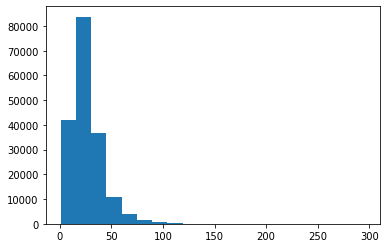

In [27]:
# Distribution of sentences length
import matplotlib.pyplot as plt
plt.hist(sen_lens,bins = 20)

In [28]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sen_lens,95))
output_seq_len

55

In [29]:
max(sen_lens)

296

### Text Vectorization Layer

In [30]:
# How many words are in our vocab? (taken from table 3.2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [31]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [32]:
text_vectorizer.adapt(train_sen)

In [33]:
import random
target_sen = random.choice(train_sen)
print(f"Text:\n{target_sen}")
print(f"\nLength of text : {len(target_sen.split())}")
print(f"\nVectorized text : {text_vectorizer([target_sen])}")

Text:
the baseline characteristics and surgical outcomes were similar between the two groups .

Length of text : 13

Vectorized text : [[  2  49 395   3 306  75   9 150  30   2  51  24   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [34]:
# How many words in our training vocab
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [36]:
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

In [37]:
print(f"Sentence before vectorization:\n{target_sen}")
vectorized_sen = text_vectorizer([target_sen])
print(f"Sentence after vectorization(before embedding):\n{vectorized_sen}")
embedded_sen = token_embed(vectorized_sen)
print(f"Sentence after embedding):\n{embedded_sen}\n")
print(f"Embedded Sentence shape : {embedded_sen.shape}")

Sentence before vectorization:
the baseline characteristics and surgical outcomes were similar between the two groups .
Sentence after vectorization(before embedding):
[[  2  49 395   3 306  75   9 150  30   2  51  24   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
Sentence after embedding):
[[[ 0.02534714  0.01165288 -0.02990514 ...  0.0188596   0.03117308
    0.02963604]
  [-0.01562551 -0.04000155  0.04649849 ... -0.01950258 -0.03688203
    0.01942023]
  [ 0.02244265  0.02173337  0.00349306 ... -0.01480082  0.02374563
    0.01114257]
  ...
  [ 0.04511494  0.03332502  0.0011263  ...  0.00558686 -0.02211616
    0.01719796]
  [ 0.04511494  0.03332502  0.0011263  ...  0.00558686 -0.02211616
    0.01719796]
  [ 0.04511494  0.03332502  0.0011263  ...  0.00558686 -0.02211616
    0.01719796]]]

Embedded Sentence shape : (1, 55, 128)


### Creating datasets (making sure data loads as fast as possible)

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen,train_labels_oh))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sen,val_labels_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen,test_labels_oh))
 
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [39]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1 : Conv1D with Token Embedding

In [40]:
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

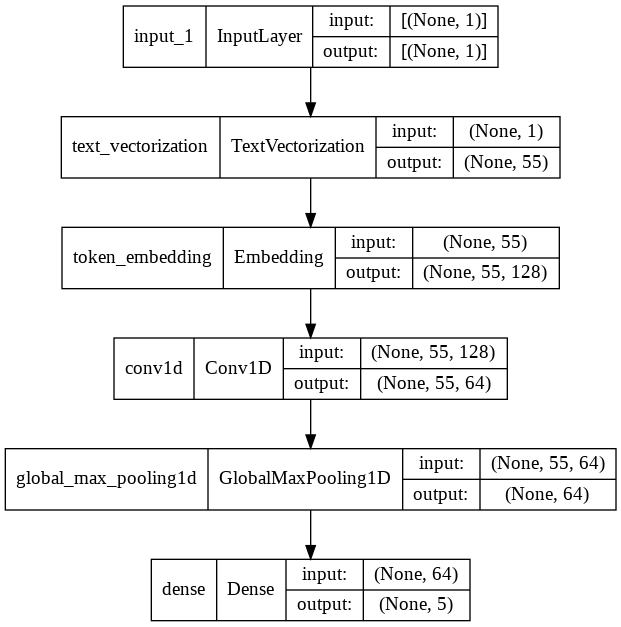

In [42]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

In [43]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=  int(0.1*len(train_dataset)),
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 17s 14ms/step - loss: 0.8235 - accuracy: 0.6902 - val_loss: 0.5838 - val_accuracy: 0.7886
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5741 - accuracy: 0.7904 - val_loss: 0.5389 - val_accuracy: 0.7989
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5445 - accuracy: 0.8011 - val_loss: 0.5181 - val_accuracy: 0.8032
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5231 - accuracy: 0.8087 - val_loss: 0.5163 - val_accuracy: 0.8065
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5293 - accuracy: 0.8088 - val_loss: 0.4965 - val_accuracy: 0.8132


```
WITH GlobalAveragePooling LAYER

Epoch 1/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5170 - accuracy: 0.8177 - val_loss: 0.5937 - val_accuracy: 0.7842
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.4547 - accuracy: 0.8396 - val_loss: 0.6010 - val_accuracy: 0.7806
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.4440 - accuracy: 0.8429 - val_loss: 0.6081 - val_accuracy: 0.7796
Epoch 4/5
562/562 [==============================] - 8s 13ms/step - loss: 0.5877 - accuracy: 0.7887 - val_loss: 0.5737 - val_accuracy: 0.7909
Epoch 5/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5851 - accuracy: 0.7932 - val_loss: 0.5550 - val_accuracy: 0.7962
```

In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.4955 - accuracy: 0.8175


[0.4954862594604492, 0.817489743232727]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

(30212, 5)

In [46]:
model_1_preds = tf.argmax(model_1_pred_probs,axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [47]:
model_1_results = calculate_results(y_pred=model_1_preds,
                                    y_true = val_labels_encoded)
model_1_results

{'accuracy': 81.74897391764861,
 'f1': 0.8151311687491072,
 'precision': 0.8195820977342692,
 'recall': 0.8174897391764862}

### Model 2 : Feauture extraction with pretrained token embediings

In [48]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "USE")

In [49]:
random_train_sen = random.choice(train_sen)
print(f"Random sentence:\n {random_train_sen}")
use_embedded_sen = tf_hub_embedding_layer([random_train_sen])
print(f"Sentence after embedding :\n{use_embedded_sen[0][:20]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sen[0])}")

Random sentence:
 we acknowledge results of this study may be intricately tied to the choice of a single pizza lunch , as other ad libitum meal options could have resulted in different outcomes .
Sentence after embedding :
[-0.00576375 -0.04687246 -0.03951593  0.0653806   0.01574884  0.00878026
  0.00544879  0.03209597  0.06234221  0.03837391 -0.0267103  -0.05289728
  0.05861336  0.08742282 -0.09495991 -0.01911428 -0.0039692   0.01894308
 -0.06641181 -0.02114329]

Length of sentence embedding: 512


In [50]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
# print(pretrained_embedding.shape)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

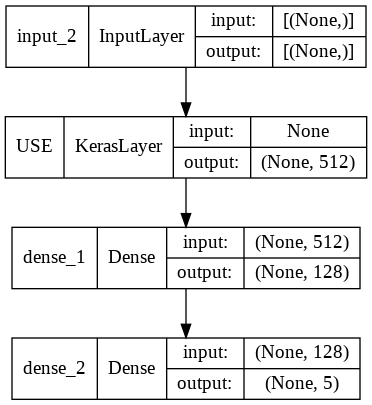

In [51]:
tf.keras.utils.plot_model(model_2,show_shapes=True)

In [52]:
history_model_2 = model_2.fit(train_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))
                              )

Epoch 1/5
562/562 [==============================] - 14s 19ms/step - loss: 0.9192 - accuracy: 0.6472 - val_loss: 0.7945 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7665 - accuracy: 0.7001 - val_loss: 0.7505 - val_accuracy: 0.7088
Epoch 3/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7483 - accuracy: 0.7143 - val_loss: 0.7333 - val_accuracy: 0.7151
Epoch 4/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7146 - accuracy: 0.7263 - val_loss: 0.7060 - val_accuracy: 0.7291
Epoch 5/5
562/562 [==============================] - 11s 19ms/step - loss: 0.7235 - accuracy: 0.7239 - val_loss: 0.6863 - val_accuracy: 0.7350


In [53]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6950 - accuracy: 0.7356


[0.6950035095214844, 0.735568642616272]

In [54]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[6.5558791e-01, 2.2100918e-01, 2.8249857e-03, 1.1095728e-01,
        9.6205855e-03],
       [4.5790026e-01, 4.4805974e-01, 6.2521924e-03, 8.5773520e-02,
        2.0143643e-03],
       [3.6256850e-01, 6.7015760e-02, 4.1440856e-02, 4.8357961e-01,
        4.5395315e-02],
       ...,
       [2.0476258e-03, 2.3893046e-03, 1.1620044e-01, 8.4537308e-04,
        8.7851727e-01],
       [2.2013499e-03, 2.4848830e-02, 4.7687045e-01, 6.7313429e-04,
        4.9540630e-01],
       [1.4747912e-01, 4.5246729e-01, 3.5675663e-01, 2.4710435e-03,
        4.0825851e-02]], dtype=float32)

In [55]:
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [56]:
model_2_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_2_preds
)
model_2_results

{'accuracy': 73.55686482192506,
 'f1': 0.7299758991149137,
 'precision': 0.7321098086222216,
 'recall': 0.7355686482192506}

### Creating a character tokenizer

In [57]:
train_sen[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [58]:
def split_to_chars(text):
    return " ".join(list(text))

split_to_chars(random_train_sen)

'w e   a c k n o w l e d g e   r e s u l t s   o f   t h i s   s t u d y   m a y   b e   i n t r i c a t e l y   t i e d   t o   t h e   c h o i c e   o f   a   s i n g l e   p i z z a   l u n c h   ,   a s   o t h e r   a d   l i b i t u m   m e a l   o p t i o n s   c o u l d   h a v e   r e s u l t e d   i n   d i f f e r e n t   o u t c o m e s   .'

In [59]:
train_chars = [split_to_chars(sentence) for sentence in train_sen]
val_chars = [split_to_chars(sentence) for sentence in val_sen]
test_chars = [split_to_chars(sentence) for sentence in test_sen]

test_chars[:5]

['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .',
 'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .',
 'l i v e r   f u n c t i o n   t e s t s   (   l f t s   )   w e r e   m e a s u r e d   a t   @   t i m e   p o i n t s   f r o m   b a s e l i n e   ,   a t   d i s c h a r g e   ,   a n d   u p   t o   @   m o n t h s   f o l l o w - u p   .',
 's u r v i v a l   a n a l y s e s   w e r e   u s e d   t o   a s s e s s   t h e   a s s o c i a t i o n   b e t w e 

In [60]:
# Avg character length
char_lens = [len(sentence) for sentence in train_sen]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

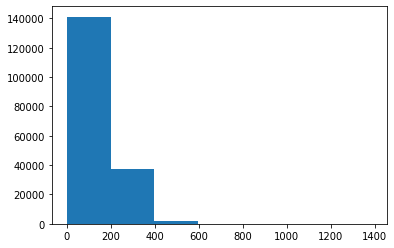

In [61]:
# Check distribution

import matplotlib.pyplot as plt
plt.hist(char_lens,bins = 7)

In [62]:
# What character length covers 95% of the lengths?
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [63]:
# Get all keyboard characters
import string
alphabet=  string.ascii_lowercase + string.digits+ string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# Char level token vectorizer
num_char_tokens = len(alphabet) + 2 # for space and UNK(Unkown)
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer",
                                    # standardize = None
                                    )

In [65]:
char_vectorizer.adapt(train_chars)

In [66]:
# With no standardization

# char_vocab = char_vectorizer.get_vocabulary()
# print(f"Number of different characters in character vocab : {len(char_vocab)}")
# print(f"5 most common characters : {char_vocab[:5]}")
# print(f"5 least common characters : {char_vocab[-5:]}")

```
OUTPUT
Number of different characters in character vocab : 57
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters : ['|', '"', ']', '\\', '[']
```

In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab : {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters : {char_vocab[-5:]}")

Number of different characters in character vocab : 28
5 most common characters : ['', '[UNK]', 'e', 't', 'i']
5 least common characters : ['k', 'x', 'z', 'q', 'j']


In [68]:
random_train_chars = random.choice(train_chars)
print(f"Charified text : \n{random_train_chars}")
print(f"\nLength of random_train_chars : {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars : \n{vectorized_chars}")
print(f"length of vectorized chars : {len(vectorized_chars[0])}")

Charified text : 
i t   i s   i m p o r t a n t   f o r   c l i n i c i a n s   t o   a s s e s s   t h e   f u n c t i o n   o f   t h e   h i p   a n d   k n e e   a s   w e l l   a s   t h e   a n k l e   ,   a n d   t o   i n c o r p o r a t e   c o o r d i n a t i o n   t r a i n i n g   f o r   t h e   e n t i r e   l o w e r   l i m b   i n t o   r e h a b i l i t a t i o n   a f t e r   l a t e r a l   a n k l e   s p r a i n s   .

Length of random_train_chars : 177

Vectorized chars : 
[[ 4  3  4  9  4 15 14  7  8  3  5  6  3 17  7  8 11 12  4  6  4 11  4  5
   6  9  3  7  5  9  9  2  9  9  3 13  2 17 16  6 11  3  4  7  6  7 17  3
  13  2 13  4 14  5  6 10 23  6  2  2  5  9 20  2 12 12  5  9  3 13  2  5
   6 23 12  2  5  6 10  3  7  4  6 11  7  8 14  7  8  5  3  2 11  7  7  8
  10  4  6  5  3  4  7  6  3  8  5  4  6  4  6 18 17  7  8  3 13  2  2  6
   3  4  8  2 12  7 20  2  8 12  4 15 22  4  6  3  7  8  2 13  5 22  4 12
   4  3  5  3  4  7  6  5 17  3  2  8 12  5  3  2  8  5

### Creating a charcater level embedding

In [69]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25, # From paper
                              mask_zero = False,
                              name = "char_embed")

In [70]:
print(f"Charified text : \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embediing) : \n{char_embed_example}\n")
print(f"Character Embediing shape : {char_embed_example.shape}")

Charified text : 
i t   i s   i m p o r t a n t   f o r   c l i n i c i a n s   t o   a s s e s s   t h e   f u n c t i o n   o f   t h e   h i p   a n d   k n e e   a s   w e l l   a s   t h e   a n k l e   ,   a n d   t o   i n c o r p o r a t e   c o o r d i n a t i o n   t r a i n i n g   f o r   t h e   e n t i r e   l o w e r   l i m b   i n t o   r e h a b i l i t a t i o n   a f t e r   l a t e r a l   a n k l e   s p r a i n s   .

Embedded chars (after vectorization and embediing) : 
[[[-0.00085988  0.01505944 -0.00910474 ... -0.00149864  0.02714011
    0.034167  ]
  [-0.00950197 -0.04241847 -0.03671471 ...  0.0155144  -0.00585615
   -0.0349568 ]
  [-0.00085988  0.01505944 -0.00910474 ... -0.00149864  0.02714011
    0.034167  ]
  ...
  [ 0.01275757 -0.00072476  0.03003352 ...  0.00832113  0.04376041
    0.00020935]
  [ 0.01275757 -0.00072476  0.03003352 ...  0.00832113  0.04376041
    0.00020935]
  [ 0.01275757 -0.00072476  0.03003352 ...  0.00832113  0.04376041
    0.0002093

### Creating Character level datasets

In [71]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 3 : Conv1D with character embedding

In [72]:
inputs = layers.Input(shape= (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters = 64,
                  kernel_size = 8,
                  padding = "same",
                  activation = "relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation = "softmax")(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(loss= tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [73]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           12864     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

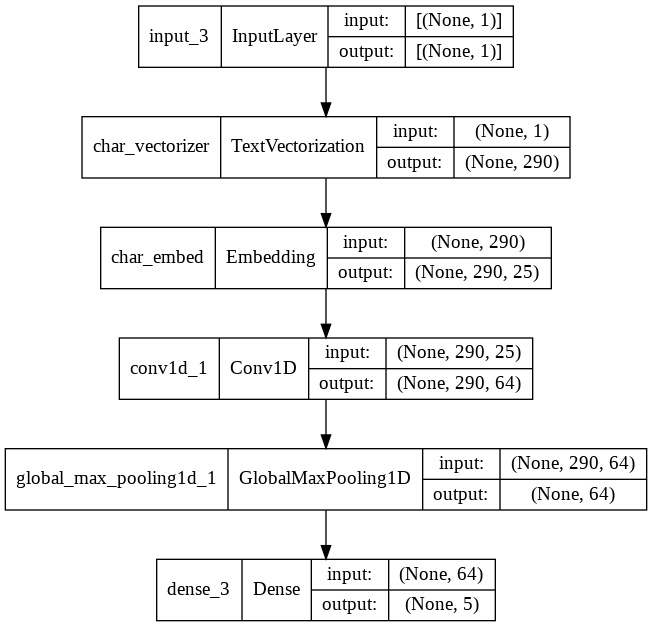

In [74]:
tf.keras.utils.plot_model(model_3,show_shapes = True)

In [75]:
history_model_3 = model_3.fit(
    train_char_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_char_dataset)),
    validation_data = val_char_dataset,
    validation_steps = int(0.1 * len(val_char_dataset))
)

Epoch 1/5
562/562 [==============================] - 7s 11ms/step - loss: 1.2244 - accuracy: 0.5147 - val_loss: 0.9822 - val_accuracy: 0.6154
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 0.9426 - accuracy: 0.6278 - val_loss: 0.8847 - val_accuracy: 0.6546
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8699 - accuracy: 0.6663 - val_loss: 0.8260 - val_accuracy: 0.6832
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 0.8204 - accuracy: 0.6834 - val_loss: 0.8044 - val_accuracy: 0.6948
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.8066 - accuracy: 0.6917 - val_loss: 0.7814 - val_accuracy: 0.7018


```
WITH GLOBAL AVERAGE POOLING

Epoch 1/5
562/562 [==============================] - 7s 11ms/step - loss: 1.4498 - accuracy: 0.3556 - val_loss: 1.3925 - val_accuracy: 0.4069
Epoch 2/5
562/562 [==============================] - 6s 10ms/step - loss: 1.3590 - accuracy: 0.4260 - val_loss: 1.3273 - val_accuracy: 0.4425
Epoch 3/5
562/562 [==============================] - 6s 10ms/step - loss: 1.3193 - accuracy: 0.4561 - val_loss: 1.3045 - val_accuracy: 0.4488
Epoch 4/5
562/562 [==============================] - 6s 10ms/step - loss: 1.2924 - accuracy: 0.4630 - val_loss: 1.2836 - val_accuracy: 0.4678
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 1.2827 - accuracy: 0.4624 - val_loss: 1.2668 - val_accuracy: 0.4727
```

In [76]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7865 - accuracy: 0.6997


[0.7865273952484131, 0.6996557712554932]

In [77]:
pred_probs = model_3.predict(val_char_dataset)
pred_probs

array([[0.142185  , 0.56365174, 0.08014348, 0.1560468 , 0.05797294],
       [0.28333834, 0.60688275, 0.01843903, 0.07355845, 0.01778139],
       [0.12804435, 0.19830705, 0.02970548, 0.6270046 , 0.01693854],
       ...,
       [0.02949012, 0.11738588, 0.05042205, 0.01206869, 0.79063326],
       [0.12596177, 0.13824613, 0.30816486, 0.17560379, 0.2520235 ],
       [0.28001648, 0.69430196, 0.01056863, 0.01047224, 0.00464071]],
      dtype=float32)

In [78]:
model_3_preds = tf.argmax(pred_probs,axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [79]:
model_3_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_3_preds)
model_3_results

{'accuracy': 69.96557659208261,
 'f1': 0.6974579547834201,
 'precision': 0.7057069403536544,
 'recall': 0.6996557659208261}

### Model 4 : MultiModal (Combining pretrained token embediings + characters embediings)

In [80]:
# 1. Setup token input/model
token_inputs = layers.Input(shape = (1,), dtype = tf.string,name = "token_input")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
x = layers.GlobalMaxPool1D()(token_embeddings)
# print(x.shape)
token_output = layers.Dense(128,activation ="relu")(x)
# print(token_output.shape)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [81]:
# 2. Setup char input/model
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(char_inputs,char_bi_lstm)

In [82]:
# 3. Concatenate token and char inputs (hybrid token embeddings)
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

In [83]:
# 4. Create output layers - adding in DropOut
combined_dropout = layers.Dropout(0.4)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.4)(combined_dense)
output_layer = layers.Dense(num_classes,activation = "softmax")(final_dropout)

In [84]:
# 5. Constrict model
model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],
                         outputs = output_layer,
                         name = "model_4"
                         )

In [85]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization[1][0]'

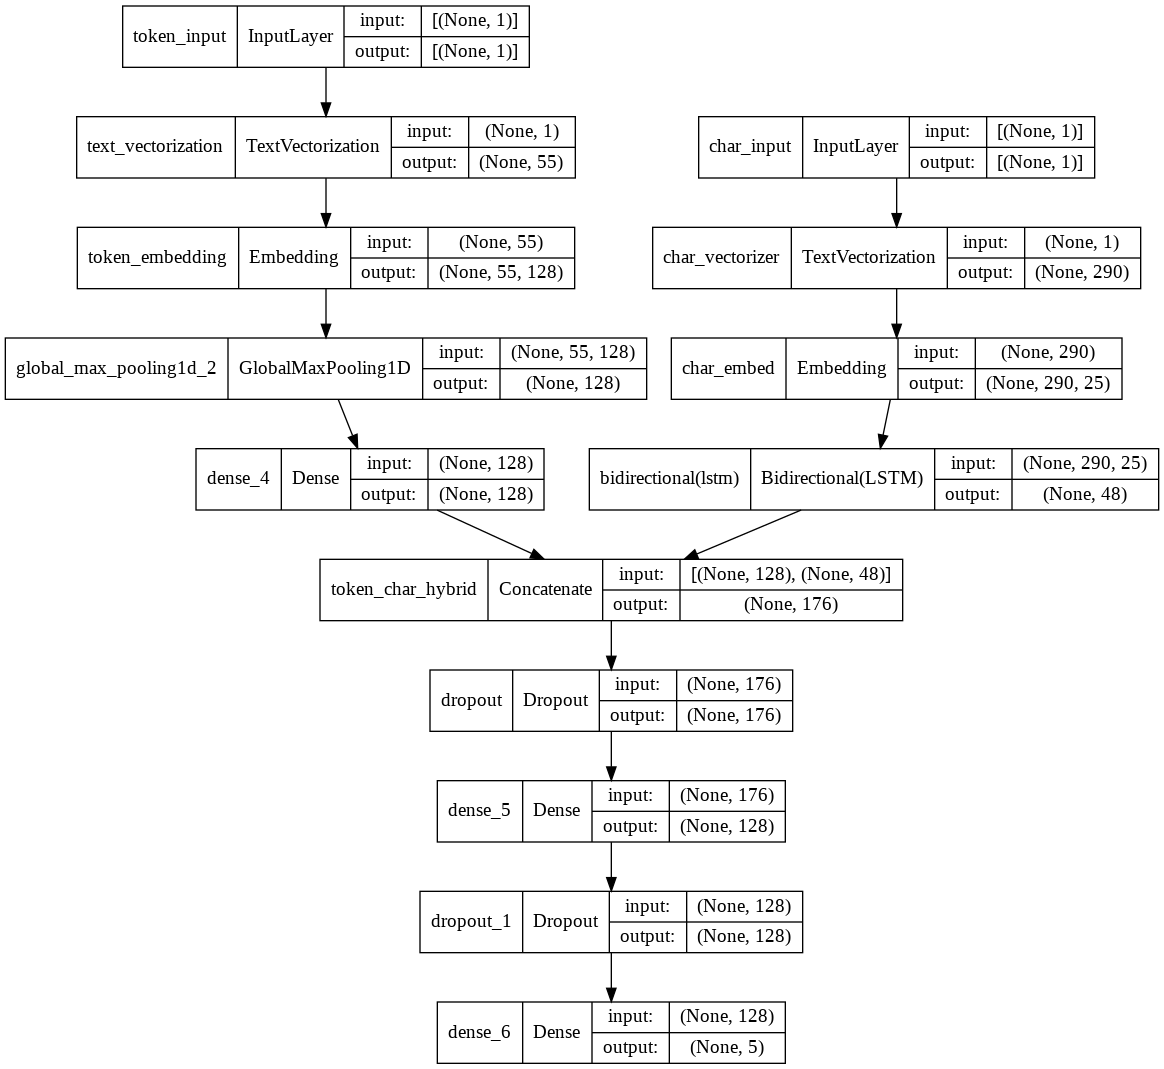

In [86]:
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [87]:
model_4.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#### Creating performant datasets pipeline

In [88]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sen,train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

len(train_token_char_dataset)

5627

In [89]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sen,val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

len(val_token_char_dataset)

945

In [90]:
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sen,test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))

test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

len(test_token_char_dataset)

942

### 

In [91]:
history_model_4 = model_4.fit(
    train_token_char_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_token_char_dataset)),
    validation_data = val_token_char_dataset,
    validation_steps = int(0.1 * len(val_token_char_dataset))
)

Epoch 1/5
562/562 [==============================] - 72s 119ms/step - loss: 0.7845 - accuracy: 0.6948 - val_loss: 0.5642 - val_accuracy: 0.7962
Epoch 2/5
562/562 [==============================] - 66s 117ms/step - loss: 0.5638 - accuracy: 0.7949 - val_loss: 0.5424 - val_accuracy: 0.8009
Epoch 3/5
562/562 [==============================] - 66s 117ms/step - loss: 0.5338 - accuracy: 0.8080 - val_loss: 0.5289 - val_accuracy: 0.7989
Epoch 4/5
562/562 [==============================] - 66s 117ms/step - loss: 0.5207 - accuracy: 0.8129 - val_loss: 0.5257 - val_accuracy: 0.7972
Epoch 5/5
562/562 [==============================] - 65s 117ms/step - loss: 0.5207 - accuracy: 0.8164 - val_loss: 0.5223 - val_accuracy: 0.8015


```
USING TENSORFLOW HUB PRETRAINED UNIVERSAL SENTENCE ENCODER FOR TOKEN EMBEDDINGS

Epoch 1/5
562/562 [==============================] - 37s 51ms/step - loss: 0.9237 - accuracy: 0.6379 - val_loss: 0.7545 - val_accuracy: 0.7081
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7524 - accuracy: 0.7078 - val_loss: 0.6931 - val_accuracy: 0.7397
Epoch 3/5
562/562 [==============================] - 24s 43ms/step - loss: 0.7301 - accuracy: 0.7191 - val_loss: 0.6637 - val_accuracy: 0.7520
Epoch 4/5
562/562 [==============================] - 28s 50ms/step - loss: 0.7006 - accuracy: 0.7333 - val_loss: 0.6477 - val_accuracy: 0.7530
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7050 - accuracy: 0.7316 - val_loss: 0.6365 - val_accuracy: 0.7560
```

In [92]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 39s 41ms/step - loss: 0.5273 - accuracy: 0.8050


[0.5272688865661621, 0.8050112724304199]

In [93]:
pred_probs = model_4.predict(val_token_char_dataset)
pred_probs

array([[7.22427070e-01, 1.12971626e-01, 4.86504147e-03, 1.56022683e-01,
        3.71357403e-03],
       [4.09462988e-01, 4.43778545e-01, 4.57358221e-03, 1.35707736e-01,
        6.47720834e-03],
       [5.09387791e-01, 2.87849866e-02, 3.15714371e-03, 4.58294272e-01,
        3.75740667e-04],
       ...,
       [2.67843589e-05, 1.15841266e-03, 3.32955504e-03, 2.68821509e-06,
        9.95482564e-01],
       [8.55212510e-02, 3.18496257e-01, 3.41010600e-01, 4.73085158e-02,
        2.07663432e-01],
       [2.12853160e-02, 9.65234876e-01, 3.31477192e-03, 2.88168318e-03,
        7.28334812e-03]], dtype=float32)

In [94]:
model_4_preds = tf.argmax(pred_probs,axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 2, 1])>

In [95]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_4_preds)
model_4_results

{'accuracy': 80.50112538064346,
 'f1': 0.8040503572082299,
 'precision': 0.8142740896006867,
 'recall': 0.8050112538064346}

**Feature Engineering**
```
Taking non obvious features from the data and encoding them numerically to help our model learn.
In our scenario we know that Objective will be at the start of the paragraph followed by methods then results and finally Conclusion.

Engineered features need to be available at test time. In our case line numbers and total lines are available.
```


In [96]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional embeddings

In [97]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

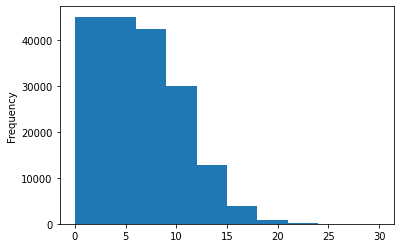

In [98]:
# Check the distribution of column
train_df.line_number.plot.hist()

In [99]:
# Use tensorflow to create one-hot-encode labels for line_number
# NOTE : --- Not using integers to remove the mathematical relation between numbers because they don't hold significance

train_line_no_oh = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_no_oh = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_no_oh = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)
train_line_no_oh[:10],train_line_no_oh.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [100]:
# How many different total line values are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

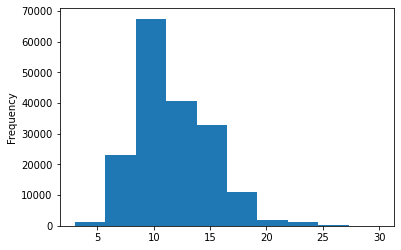

In [101]:
# Check the distribution
train_df.total_lines.plot.hist()

In [102]:
np.percentile(train_df.total_lines,95), np.percentile(train_df.total_lines,98)

(18.0, 20.0)

In [103]:
train_total_lines_no_oh = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_no_oh = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_no_oh = tf.one_hot(test_df["total_lines"].to_numpy(),depth= 20)
train_total_lines_no_oh[:10],train_total_lines_no_oh.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Creating the appropriate datasets for model 5

In [104]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_no_oh,train_total_lines_no_oh,train_sen,train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [105]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_no_oh,val_total_lines_no_oh,val_sen,val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [106]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_no_oh,test_total_lines_no_oh,test_sen,test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_oh)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

### Model 5 : Transfer learning with pretrained token embediings + character embeddings + positional embediings

In [107]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype = tf.string,name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(256,activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_output)

In [108]:
# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype = tf.string,name= "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [109]:
# 3. Line Number Model
line_no_inputs = layers.Input(shape=(15,),dtype = tf.float32,name="line_no_inputs")
x = layers.Dense(32,activation="relu")(line_no_inputs)
line_no_model = tf.keras.Model(inputs = line_no_inputs,
                               outputs = x)

In [110]:
# 4. Total Line Number Model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                      outputs = y)

In [111]:
# 5. Combine 1 and 2 into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

In [112]:
# 6. 
z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [113]:
# 7. Combine positional embediing with 5
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_no_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

In [114]:
# 8. Create output layer
output_layer = layers.Dense(num_classes,activation="softmax",name = "output_layer")(tribrid_embeddings)

In [115]:
# 9. Put together model with all kinds of inputs
model_5 = tf.keras.Model(
    inputs=[
            line_no_model.input,
            total_lines_model.input,
            token_model.input,
            char_model.input
    ],
    outputs=output_layer,
    name = "tribrid_embedding_model"
)

In [116]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inp

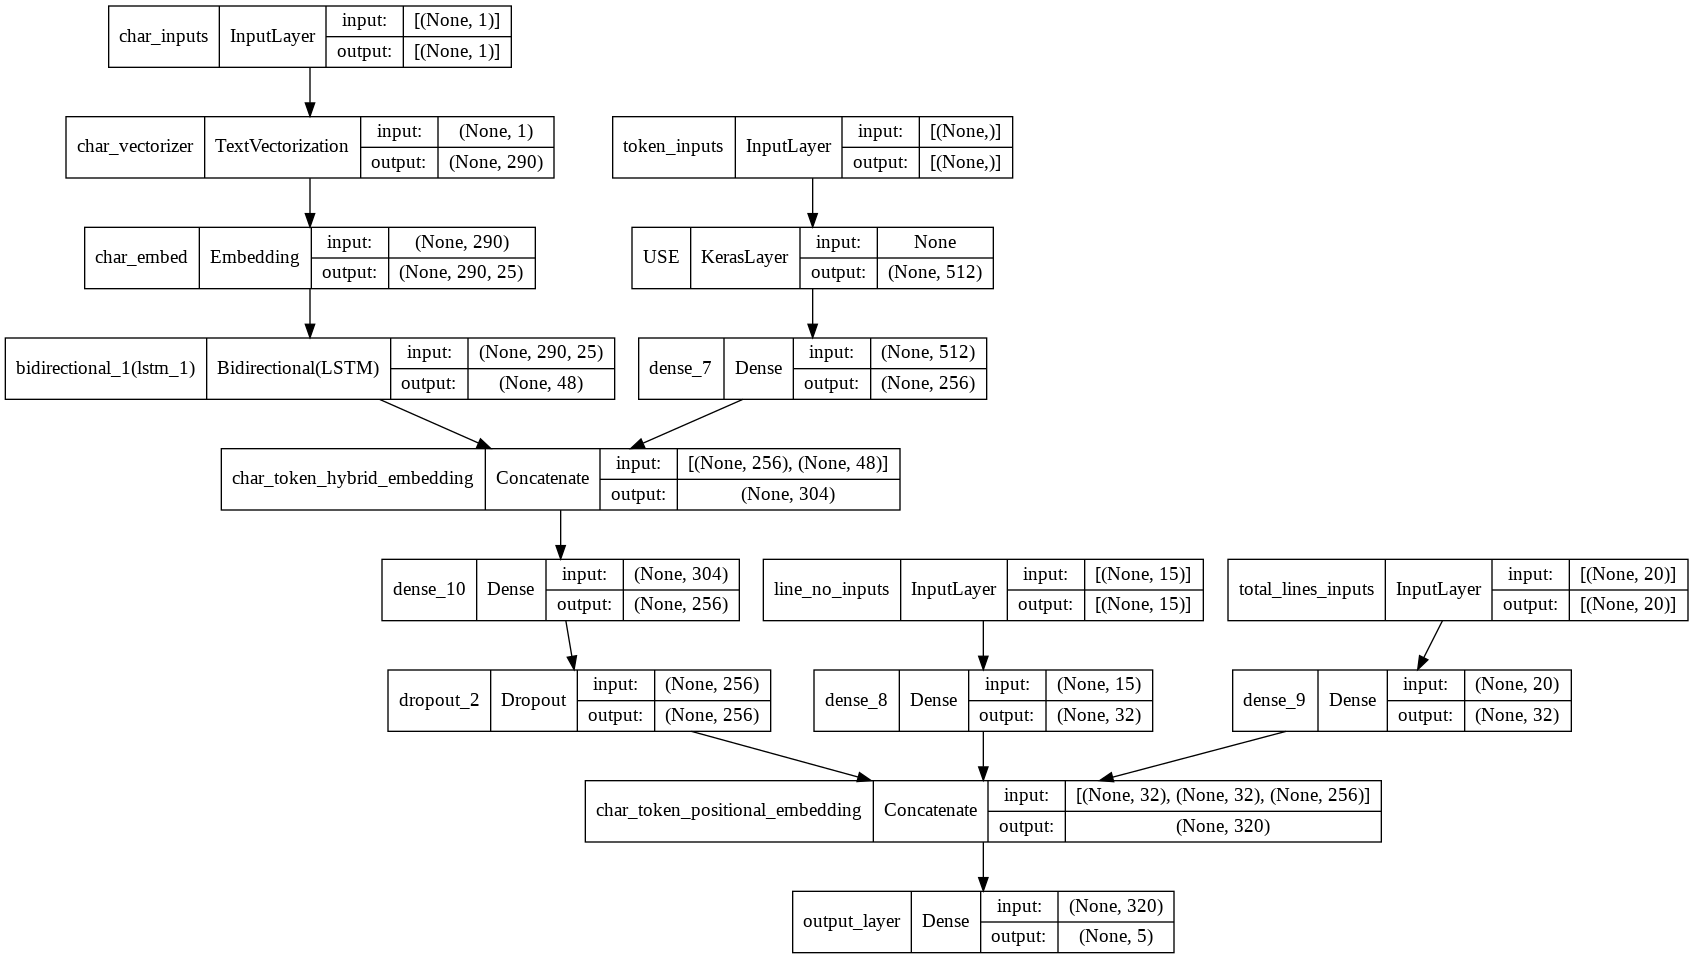

In [117]:
tf.keras.utils.plot_model(model_5,show_shapes = True)

In [118]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [119]:
history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    epochs = 5,
    steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
    validation_data = val_char_token_pos_dataset,
    validation_steps = int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/5
562/562 [==============================] - 72s 121ms/step - loss: 1.0999 - accuracy: 0.7204 - val_loss: 0.9841 - val_accuracy: 0.8009
Epoch 2/5
562/562 [==============================] - 66s 118ms/step - loss: 0.9673 - accuracy: 0.8166 - val_loss: 0.9468 - val_accuracy: 0.8305
Epoch 3/5
562/562 [==============================] - 66s 117ms/step - loss: 0.9488 - accuracy: 0.8256 - val_loss: 0.9372 - val_accuracy: 0.8331
Epoch 4/5
562/562 [==============================] - 66s 117ms/step - loss: 0.9389 - accuracy: 0.8358 - val_loss: 0.9270 - val_accuracy: 0.8381
Epoch 5/5
562/562 [==============================] - 67s 118ms/step - loss: 0.9352 - accuracy: 0.8362 - val_loss: 0.9201 - val_accuracy: 0.8451


```
USING OUR OWN CUSTOM TOKEN EMBEDDINGS

Epoch 1/5
562/562 [==============================] - 37s 50ms/step - loss: 0.9144 - accuracy: 0.8613 - val_loss: 0.9254 - val_accuracy: 0.8344
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.8224 - accuracy: 0.9202 - val_loss: 0.9171 - val_accuracy: 0.8451
Epoch 3/5
562/562 [==============================] - 22s 39ms/step - loss: 0.8015 - accuracy: 0.9311 - val_loss: 0.9403 - val_accuracy: 0.8158
Epoch 4/5
562/562 [==============================] - 26s 45ms/step - loss: 0.7935 - accuracy: 0.9347 - val_loss: 0.9160 - val_accuracy: 0.8351
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7907 - accuracy: 0.9356 - val_loss: 0.9187 - val_accuracy: 0.8374

```

In [129]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.9201 - accuracy: 0.8433


[0.9201253056526184, 0.8432741761207581]

In [121]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose = 1)
model_5_pred_probs

945/945 [==============================] - 50s 51ms/step


array([[0.60623425, 0.07882688, 0.01686531, 0.26951888, 0.02855475],
       [0.61759394, 0.08071099, 0.08264986, 0.20196775, 0.01707742],
       [0.37436906, 0.0981652 , 0.12163801, 0.35270455, 0.05312314],
       ...,
       [0.03422624, 0.05217259, 0.02871137, 0.02676314, 0.8581267 ],
       [0.02281629, 0.3095621 , 0.12540396, 0.02281476, 0.5194029 ],
       [0.12749805, 0.71961427, 0.06964859, 0.0261885 , 0.05705065]],
      dtype=float32)

In [122]:
model_5_preds = tf.argmax(model_5_pred_probs,axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [123]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                  y_pred = model_5_preds)
model_5_results

{'accuracy': 84.32741956838342,
 'f1': 0.8392685776574874,
 'precision': 0.8472110678053205,
 'recall': 0.8432741956838342}

In [124]:
model_4_results

{'accuracy': 80.50112538064346,
 'f1': 0.8040503572082299,
 'precision': 0.8142740896006867,
 'recall': 0.8050112538064346}

## Compare model results

In [125]:
model_results = pd.DataFrame(
    {
        "model_0_baseline": baseline_results,
        "model_1_custom_token_embed_conv1d": model_1_results,
        "model_2_pretrained_token_embed": model_2_results,
        "model_3_custom_char_embed_conv1d": model_3_results,
        "model_4_hybrid_char_token_embed": model_4_results,
        "model_5_tribrid_pos_char_token_embed": model_5_results
    }
)

model_results = model_results.transpose()
model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embed_conv1d,81.748974,0.819582,0.817490,0.815131
model_2_pretrained_token_embed,73.556865,0.732110,0.735569,0.729976
model_3_custom_char_embed_conv1d,69.965577,0.705707,0.699656,0.697458
model_4_hybrid_char_token_embed,80.501125,0.814274,0.805011,0.804050
model_5_tribrid_pos_char_token_embed,84.327420,0.847211,0.843274,0.839269


In [126]:
model_results["accuracy"] = model_results["accuracy"]/100

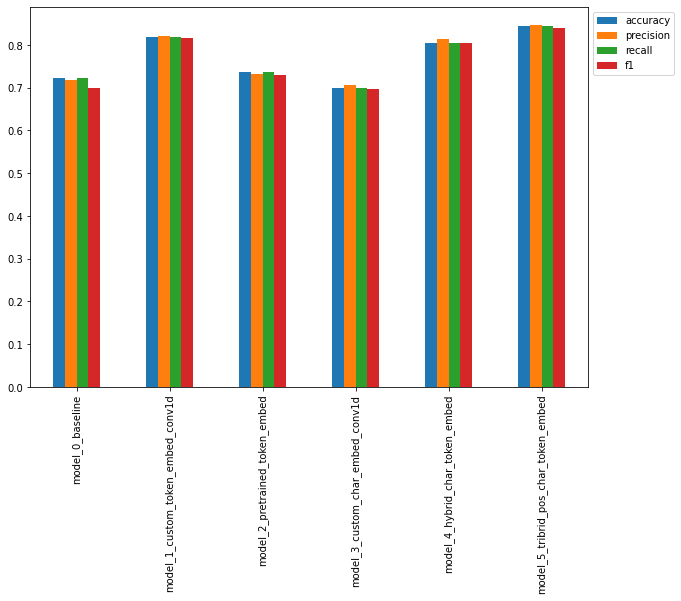

In [127]:
model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

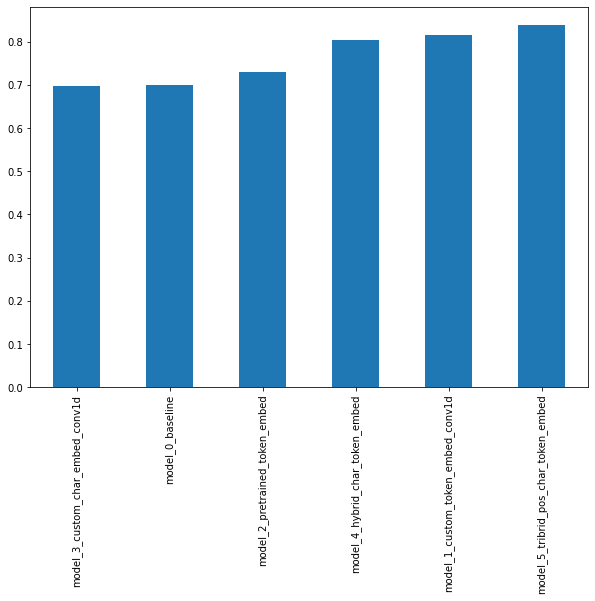

In [128]:
model_results.sort_values("f1",ascending = True)["f1"].plot(kind = "bar", figsize = (10,7))

## Evaluate model on test data

In [130]:
test_pred_probs = model_5.predict(test_char_token_pos_dataset,verbose = 1)
test_preds = tf.argmax(test_pred_probs,axis = 1)
test_preds

942/942 [==============================] - 47s 50ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [131]:
test_results = calculate_results(y_true = test_labels_encoded,
                                 y_pred = test_preds)
test_results

{'accuracy': 83.7630662020906,
 'f1': 0.8334665170356256,
 'precision': 0.8412181282216339,
 'recall': 0.837630662020906}

## Find Most Wrong predictions

In [132]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
print(test_pred_classes)

['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'METHODS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'METHODS', 'BACKGROUND', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'RESULTS', 'RESULTS', 'METHODS', 'RESULTS', 'OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'RESULTS', 'CONCLUSIONS', 'CONCLUSIONS', 'BACKGROUND', 'BACKGROUND', 'ME

In [133]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.401704,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.437256,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.837124,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.862293,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.629879,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.812936,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.490397,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.495863,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.467232,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.637871,True


In [134]:
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.962290,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.956826,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.949376,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.932308,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.927308,False
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.924326,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.923559,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.920708,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.920486,False
4860,RESULTS,we randomly assigned @ patients with drug-resi...,2,10,METHODS,0.914755,False
